# Imports

In [1]:
import os
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import cProfile

# Image Operations

1. Display Image
2. Save Image

In [2]:
def displayImageInConsole(img):
    plt.imshow(img)
    plt.show()

    
def saveImageToDisk(img, selectedQuantizationMatrix):
    cv2.imwrite("output"+selectedQuantizationMatrix+".jpeg", img)
    

# Image Compression Pipeline

The following cells contain functions described as part of the image compression pipeline implemented.

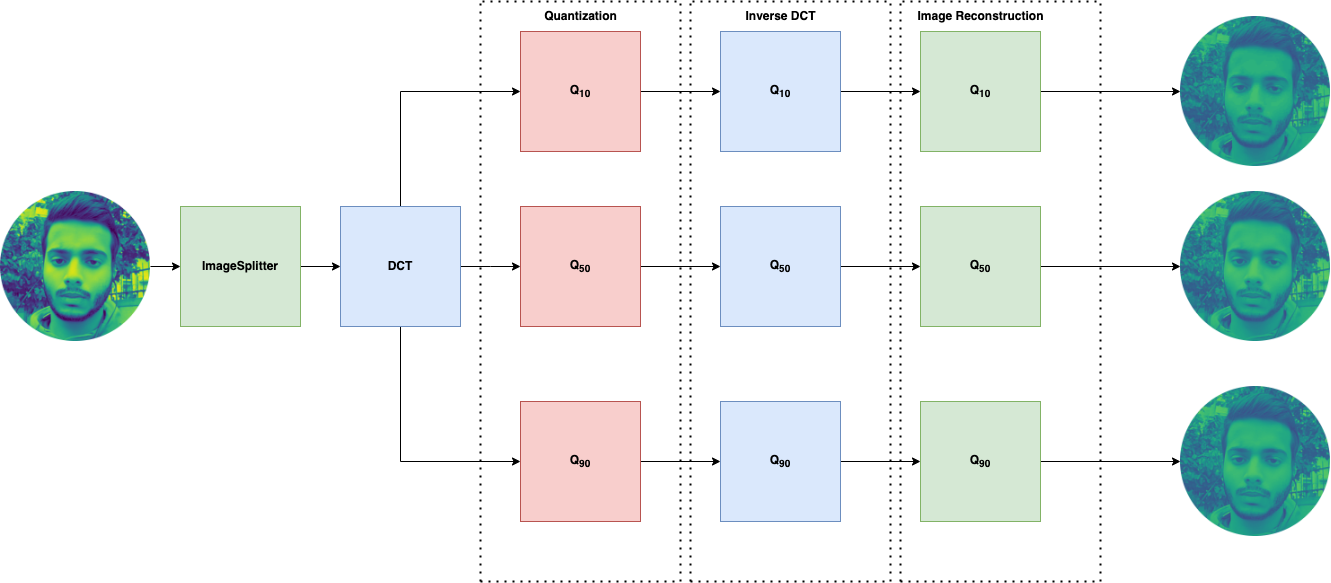



In [3]:
# Splitting images to 8x8 blocks
def splitImageIntoBlocks(img):
    height, width = len(img),len(img[0])
    sliced_img = []

    pixel_y = 0 
    for row in range(block,height+1,block):
        pixel_x = 0 
        for col in range(block,width+1,block):
            sliced_img.append(img[pixel_y:row,pixel_x:col] - np.ones((8,8))*128) 
            pixel_x = col
        pixel_y = row

    # CV2's implementation of DCT expects the image to be floating point literals                                    
    img = [np.float32(img) for img in sliced_img] 
    return img

In [4]:
# We leverage the cv2 library to apply DCT over the image
def applyDCTOnImage(img):
    dctMatrix = []
    for block in img:
        dctBlock = cv2.dct(block)
        dctMatrix.append(dctBlock)
    return dctMatrix

In [5]:
# Quantization Arrays obtained from https://www.math.cuhk.edu.hk/~lmlui/dct.pdf
def getQuantizationMatrix(quantizationMatrix):
    if quantizationMatrix == "Q10":
        return np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])
    elif quantizationMatrix == "Q50":
        return np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])
    elif quantizationMatrix == "Q90":
        return np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    else:
        return np.ones((8,8))


In [6]:
def applyQuantizationOnDCTMAtrix(dctMatrix, selectedQuantizationMatrix):
    quantizationMatrix = getQuantizationMatrix(selectedQuantizationMatrix)
    for dctMat in dctMatrix:
        for i in range(block):
            for j in range(block):
                dctMat[i,j] = np.around(dctMat[i,j] / quantizationMatrix[i,j])
    return dctMatrix 

In [7]:
def applyInverseDCTOnQuantizedImage(dctMatrix):
    inverseDCTMatrix = []
    for block in dctMatrix:
        inverseDCTBlock = cv2.idct(block)
        inverseDCTMatrix.append(inverseDCTBlock)
    return inverseDCTMatrix

In [8]:
def reconstructImage(inverseDCTMatrix, width):
    row = 0
    reconstructedImgArray = []
    for j in range(int(width/block),len(inverseDCTMatrix)+1,int(width/block)):
        reconstructedImgArray.append(np.hstack((inverseDCTMatrix[row:j])))
        row = j
    reconstructedImg = np.vstack((reconstructedImgArray))
    return reconstructedImg

In [9]:
def compressImage(input_img, block_size, quantizationMatrix):
    return reconstructImage(
               applyInverseDCTOnQuantizedImage(
                   applyQuantizationOnDCTMAtrix(
                       applyDCTOnImage(
                           splitImageIntoBlocks(input_img)), quantizationMatrix)), len(input_img[0]))

# Running and Profiling Image Compression For Various Quantization Matrix


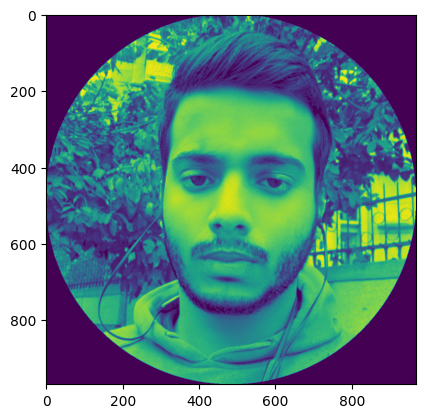

In [10]:
input_img = cv2.imread('./ProfilePhoto.png',0)
block = 8
displayImageInConsole(input_img)

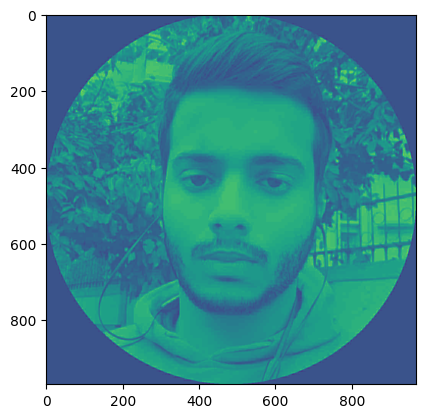

In [11]:
quantizationMatrix = "Q10"

output_compressed_img = compressImage(input_img, block, quantizationMatrix)
displayImageInConsole(output_compressed_img)
saveImageToDisk(output_compressed_img, quantizationMatrix)

In [12]:
cProfile.run('compressImage(input_img, block, "Q10")')

         6737069 function calls (6736825 primitive calls) in 4.139 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.017    0.017 1483044535.py:1(applyInverseDCTOnQuantizedImage)
        1    0.000    0.000    0.000    0.000 1501077252.py:2(getQuantizationMatrix)
        1    0.003    0.003    0.017    0.017 1611787791.py:2(applyDCTOnImage)
        1    1.820    1.820    4.003    4.003 2832481552.py:1(applyQuantizationOnDCTMAtrix)
        1    0.009    0.009    0.009    0.009 2879020982.py:15(<listcomp>)
        1    0.048    0.048    0.089    0.089 2879020982.py:2(splitImageIntoBlocks)
        1    0.005    0.005    4.139    4.139 490915454.py:1(compressImage)
        1    0.000    0.000    0.009    0.009 939121419.py:1(reconstructImage)
   937024    0.285    0.000    2.183    0.000 <__array_function__ internals>:177(around)
      121    0.000    0.000    0.004    0.000 <__array_function__ in

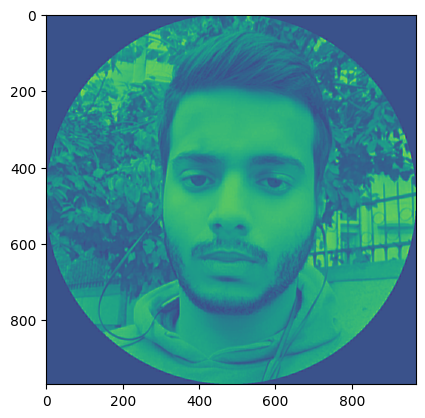

In [13]:
quantizationMatrix = "Q50"

output_compressed_img = compressImage(input_img, block, quantizationMatrix)
displayImageInConsole(output_compressed_img)
saveImageToDisk(output_compressed_img, quantizationMatrix)

In [14]:
cProfile.run('compressImage(input_img, block, "Q50")')

         6737069 function calls (6736825 primitive calls) in 4.089 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.016    0.016 1483044535.py:1(applyInverseDCTOnQuantizedImage)
        1    0.000    0.000    0.000    0.000 1501077252.py:2(getQuantizationMatrix)
        1    0.003    0.003    0.016    0.016 1611787791.py:2(applyDCTOnImage)
        1    1.784    1.784    3.956    3.956 2832481552.py:1(applyQuantizationOnDCTMAtrix)
        1    0.009    0.009    0.009    0.009 2879020982.py:15(<listcomp>)
        1    0.047    0.047    0.087    0.087 2879020982.py:2(splitImageIntoBlocks)
        1    0.005    0.005    4.089    4.089 490915454.py:1(compressImage)
        1    0.000    0.000    0.009    0.009 939121419.py:1(reconstructImage)
   937024    0.280    0.000    2.172    0.000 <__array_function__ internals>:177(around)
      121    0.000    0.000    0.004    0.000 <__array_function__ in

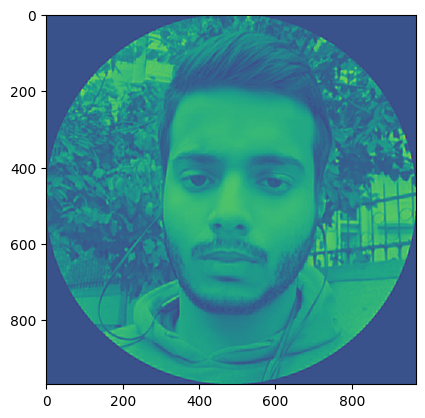

In [15]:
quantizationMatrix = "Q90"

output_compressed_img = compressImage(input_img, block, quantizationMatrix)
displayImageInConsole(output_compressed_img)
saveImageToDisk(output_compressed_img, quantizationMatrix)

In [16]:
cProfile.run('compressImage(input_img, block, "Q90")')

         6737069 function calls (6736825 primitive calls) in 4.161 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.016    0.016 1483044535.py:1(applyInverseDCTOnQuantizedImage)
        1    0.000    0.000    0.000    0.000 1501077252.py:2(getQuantizationMatrix)
        1    0.003    0.003    0.016    0.016 1611787791.py:2(applyDCTOnImage)
        1    1.820    1.820    4.027    4.027 2832481552.py:1(applyQuantizationOnDCTMAtrix)
        1    0.009    0.009    0.009    0.009 2879020982.py:15(<listcomp>)
        1    0.047    0.047    0.087    0.087 2879020982.py:2(splitImageIntoBlocks)
        1    0.005    0.005    4.161    4.161 490915454.py:1(compressImage)
        1    0.000    0.000    0.009    0.009 939121419.py:1(reconstructImage)
   937024    0.279    0.000    2.207    0.000 <__array_function__ internals>:177(around)
      121    0.000    0.000    0.004    0.000 <__array_function__ in